# Introduction to Guassian Processes and Active Learning
A. Gilad Kusne aaron.kusne@nist.gov \
Austin McDannald, austin.mcdannald@nist.gov

Install the required packages:

In [1]:
!pip install GPy # GPFlow, GPyTorch
!pip install GPyOpt

ERROR: Invalid requirement: '#'


In [2]:
# Support for math
import numpy as np

# Plotting tools
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy
import GPyOpt

import math

from numpy.random import seed
seed(12345)

In [3]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys
import matplotlib.pyplot as plt

In [4]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys

from fun_floodestimate import FloodHeight
from fun_floodestimate import FloodHeightWall
from fun_floodestimate import FloodTravelSectGroup
from fun_floodestimate import SurfaceVolFunc
from fun_damagecost import damage

from fun_objective_loop_manywalls import objective
#from fun_objective_loop import constraint1
#from fun_objective_loop import constraint2
#from fun_objective_loop import constraint3

#input_name = sys.argv[1]
output_name = sys.argv[1]

#x = np.loadtxt(input_name)

#ws = int(sys.argv[1])
#we = int(sys.argv[2])
#wh = float(sys.argv[3])
#wall_year = int(sys.argv[4])
#fname = sys.argv[5]

# setup
# Surface Volume Input
ndiv18 = 18
sections = [10,11,5,12,1,13,16,4,17,15,3,14,0,9,8,7,2,6]
files = glob.glob('NewSurfaceVolumeCombined/LMN_div18_*.csv') 
groupcsvfiles = glob.glob('NewSurfaceVolumeGrouped/LMN_div18_*.csv') 
H = np.append(np.linspace(0,3,13),np.linspace(3.5,7,8))

SVfg1 = np.zeros([ndiv18,2]);  SVfg2 = np.zeros([ndiv18,2]);  SVfg3 = np.zeros([ndiv18,2]);  SVfg4 = np.zeros([ndiv18,2])
SVfg5 = np.zeros([ndiv18,2]);  SVfg6 = np.zeros([ndiv18,2]);  SVfg7 = np.zeros([ndiv18,2]);  SVfg8 = np.zeros([ndiv18,2])
SVfg9 = np.zeros([ndiv18,2]);  SVfg10 = np.zeros([ndiv18,2]); SVfg11 = np.zeros([ndiv18,2]); SVfg12 = np.zeros([ndiv18,2])
SVfg13 = np.zeros([ndiv18,2]); SVfg14 = np.zeros([ndiv18,2]); SVfg15 = np.zeros([ndiv18,2]); SVfg16 = np.zeros([ndiv18,2])
SVfg17 = np.zeros([ndiv18,2]); SVfg18 = np.zeros([ndiv18,2]); SVfg19 = np.zeros([ndiv18,2]); SVfg20= np.zeros([ndiv18,2])

i = 0
for f in groupcsvfiles:
    surfaceVg = pd.read_csv(f)["volume"]
    SVfg1[i,:],SVfg2[i,:],SVfg3[i,:],SVfg4[i,:],SVfg5[i,:],SVfg6[i,:],SVfg7[i,:],SVfg8[i,:],SVfg9[i,:],SVfg10[i,:],SVfg11[i,:],SVfg12[i,:],SVfg13[i,:],SVfg14[i,:],SVfg15[i,:],SVfg16[i,:],SVfg17[i,:],SVfg18[i,:],SVfg19[i,:],SVfg20[i,:] = SurfaceVolFunc(surfaceVg,H)
    i = i + 1 


SVf1 = np.zeros([ndiv18,2]);  SVf2 = np.zeros([ndiv18,2]);  SVf3 = np.zeros([ndiv18,2]);  SVf4 = np.zeros([ndiv18,2])
SVf5 = np.zeros([ndiv18,2]);  SVf6 = np.zeros([ndiv18,2]);  SVf7 = np.zeros([ndiv18,2]);  SVf8 = np.zeros([ndiv18,2])
SVf9 = np.zeros([ndiv18,2]);  SVf10 = np.zeros([ndiv18,2]); SVf11 = np.zeros([ndiv18,2]); SVf12 = np.zeros([ndiv18,2])
SVf13 = np.zeros([ndiv18,2]); SVf14 = np.zeros([ndiv18,2]); SVf15 = np.zeros([ndiv18,2]); SVf16 = np.zeros([ndiv18,2])
SVf17 = np.zeros([ndiv18,2]); SVf18 = np.zeros([ndiv18,2]); SVf19 = np.zeros([ndiv18,2]); SVf20= np.zeros([ndiv18,2])

SV_all = []
i = 0
for f in files:
    surfaceV_height = pd.read_csv(f)
    surfaceV = surfaceV_height["volume"]
    SV_all = np.append(SV_all,surfaceV)
    SVf1[i,:],SVf2[i,:],SVf3[i,:],SVf4[i,:],SVf5[i,:],SVf6[i,:],SVf7[i,:],SVf8[i,:],SVf9[i,:],SVf10[i,:],SVf11[i,:],SVf12[i,:],SVf13[i,:],SVf14[i,:],SVf15[i,:],SVf16[i,:],SVf17[i,:],SVf18[i,:],SVf19[i,:],SVf20[i,:] = SurfaceVolFunc(surfaceV,H)
    i = i+1
SV_all = SV_all.reshape(18,21)

roughness = pd.read_csv("Roughness.csv")["Roughness"]
slope = pd.read_csv("LMN_Slope.csv")["Slope"]

# Setup - Division Connectivities
sect3 = np.zeros([len(sections)-6,7])
k = 3
for i in sections[3:-3]:
    sect3[k-3] = [sections[k-3],sections[k-2],sections[k-1],i,sections[k+1],sections[k+2],sections[k+3]]
    k = k + 1

sect0  = [sections[0],sections[1],sections[2],sections[3]] 
sect1  = [sections[0],sections[1],sections[2],sections[3],sections[4]]
sect2  = [sections[0],sections[1],sections[2],sections[3],sections[4],sections[5]]

sect_3 = [sections[-6],sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_2 = [sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_1 = [sections[-4],sections[-3],sections[-2],sections[-1]]

# initial value
total_cost = 75*10**9 # total cost without any protective measure
cost_opt   = total_cost
x_opt 	   = [0,2040,0,0]

def objective2(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=2)
    print(total_cost_new)
    return total_cost_new

def objective3(x_input):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    we = int(min(x_input[1],162))
    wh = x_input[2]
    x[ws:we] = np.ones(we-ws)*wh
    print(x_input)
    
    total_cost_new, wall_cost = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    return total_cost_new

cons3 = [{'type': 'ineq', 'fun': lambda x:  x[1] - x[0]},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 162-x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: 5.0-x[2]}]





This function allows us to plot Gaussian processes.

In [6]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)

### The Kernel is key:
Gaussian Process: P(X) ~ N($\mu$,K)
* $\mu(x^*)=K_{*x}(K_{xx}+\sigma^2I)^{-1}y$
* $\sigma^2(x^*)=K_{**}-K_{*x}(K_{xx}+\sigma^2I)^{-1}K_{*x}^T$

Let's see how using different kernels impacts the possible curves.

Applications for each?

The following plots demonstrate samples from a Gaussian process prior and the corresponding covariance matrix


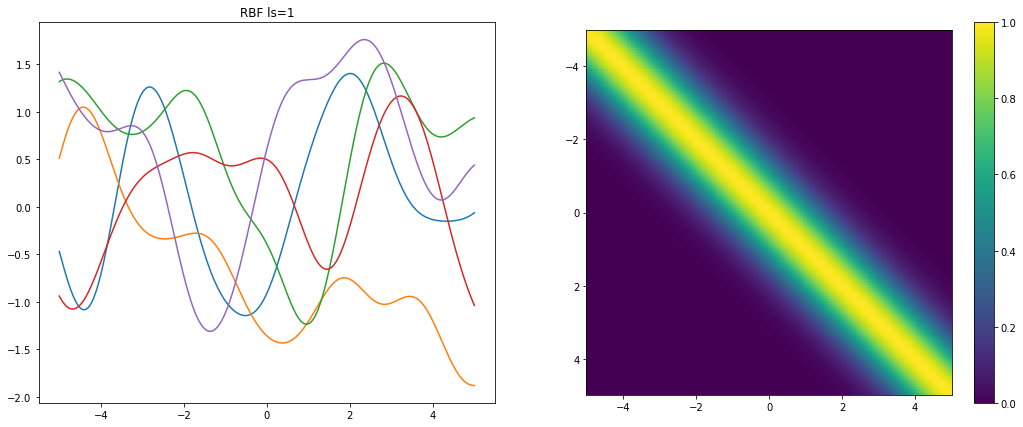

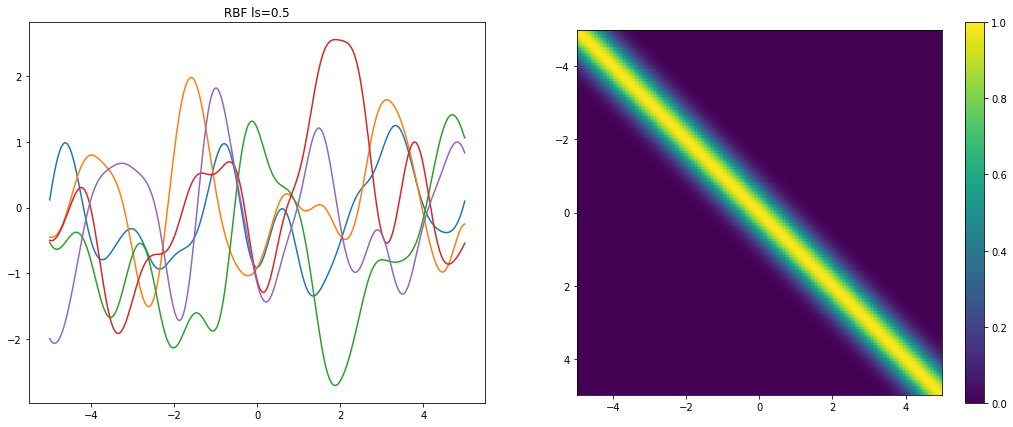

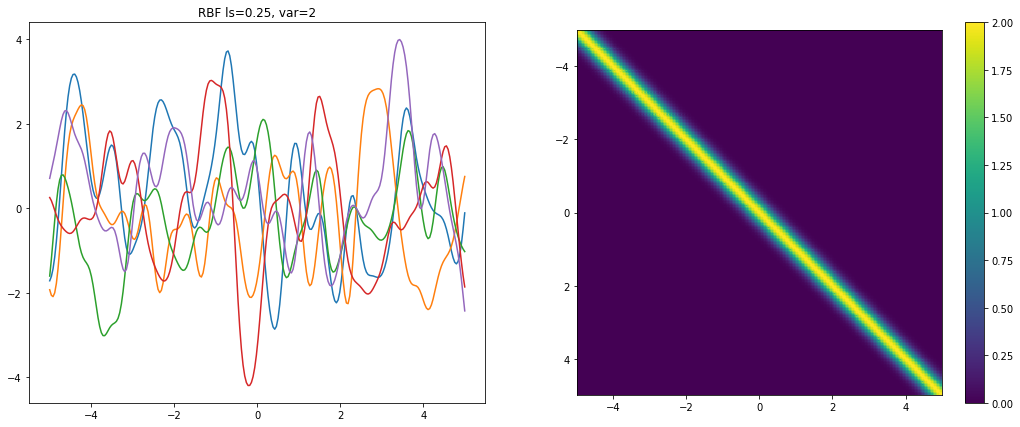

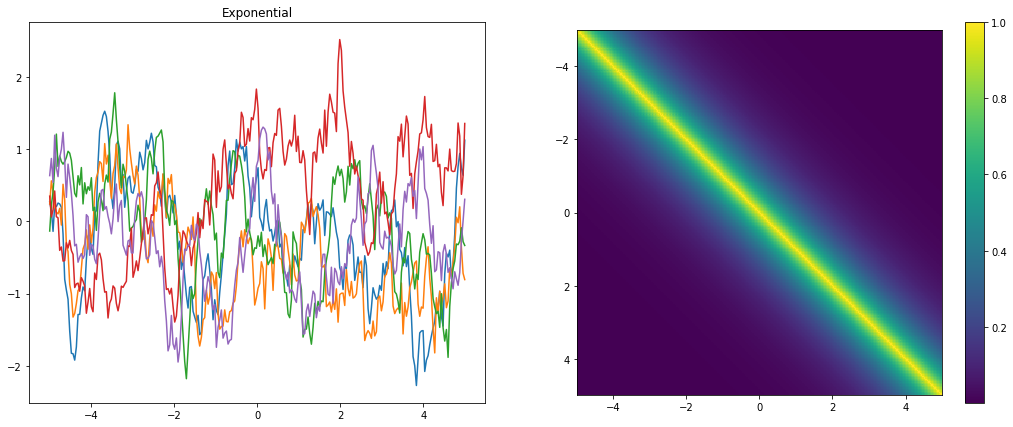

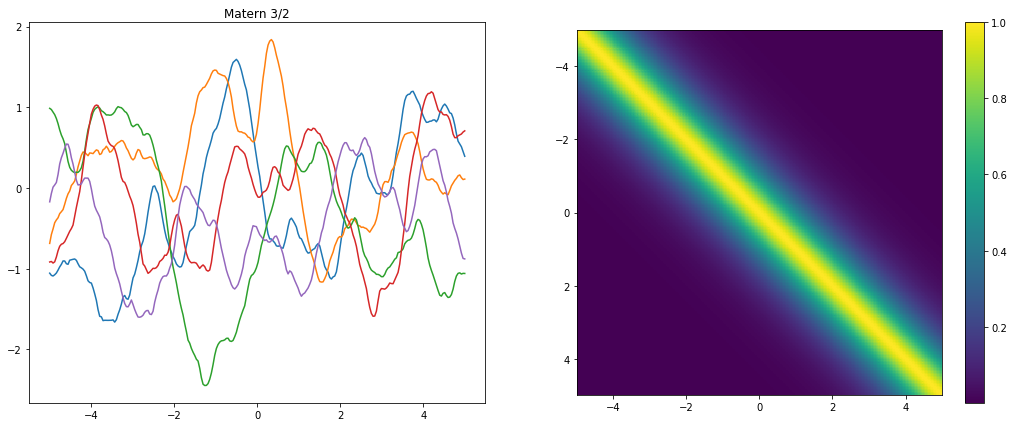

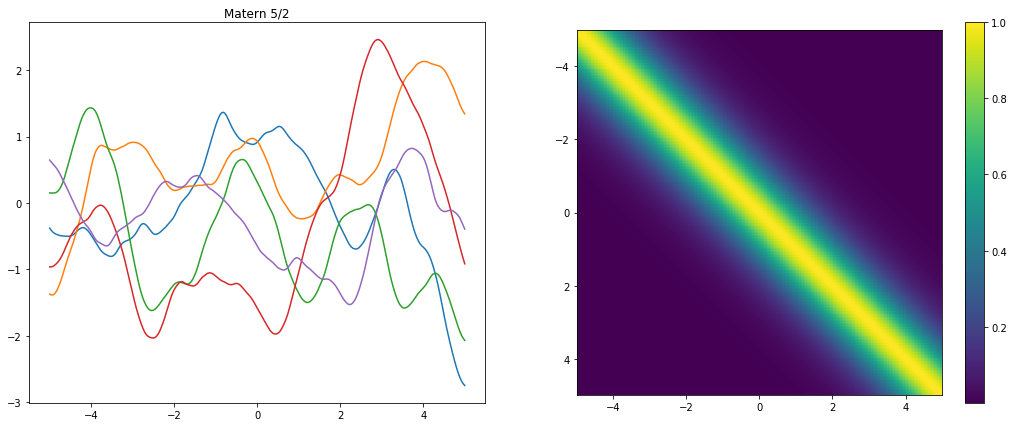

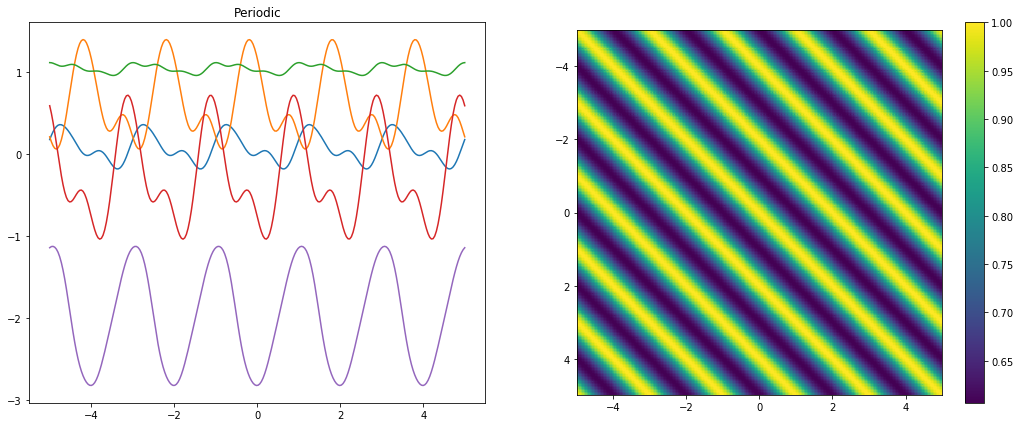

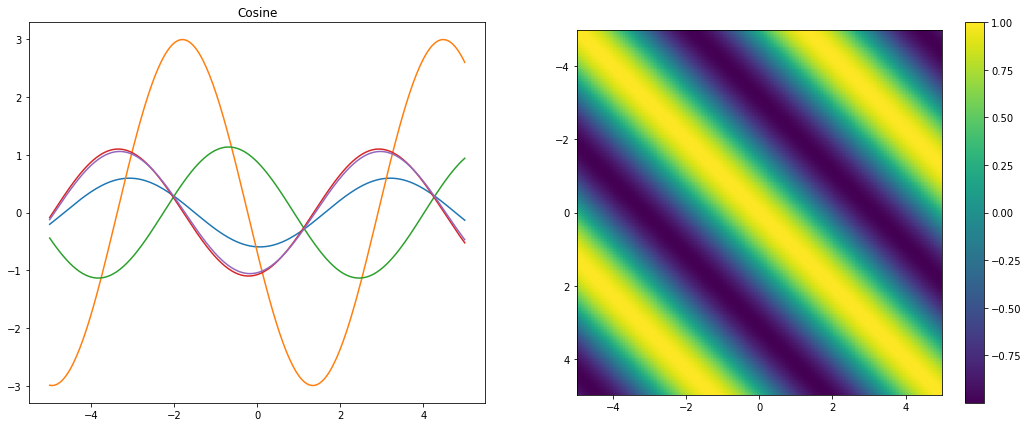

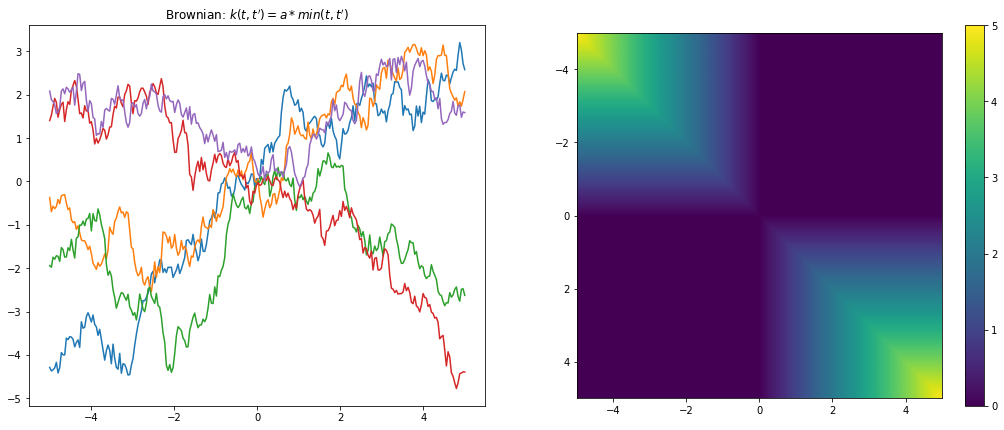

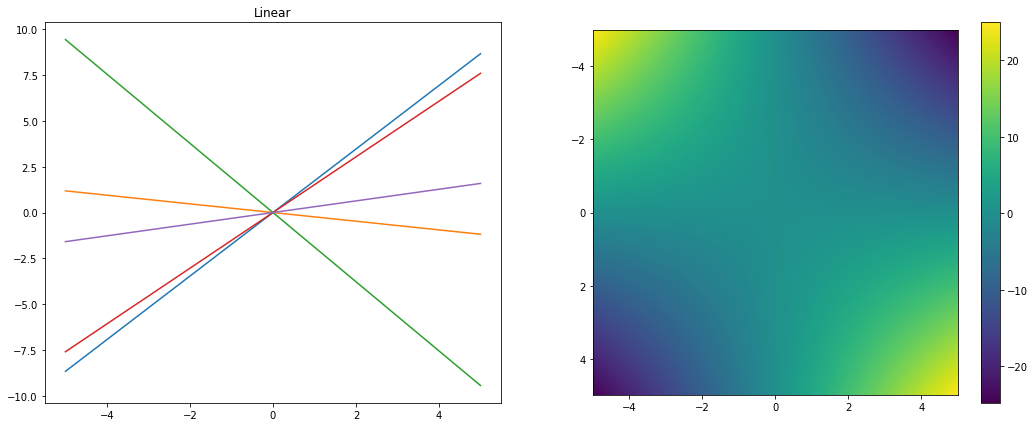

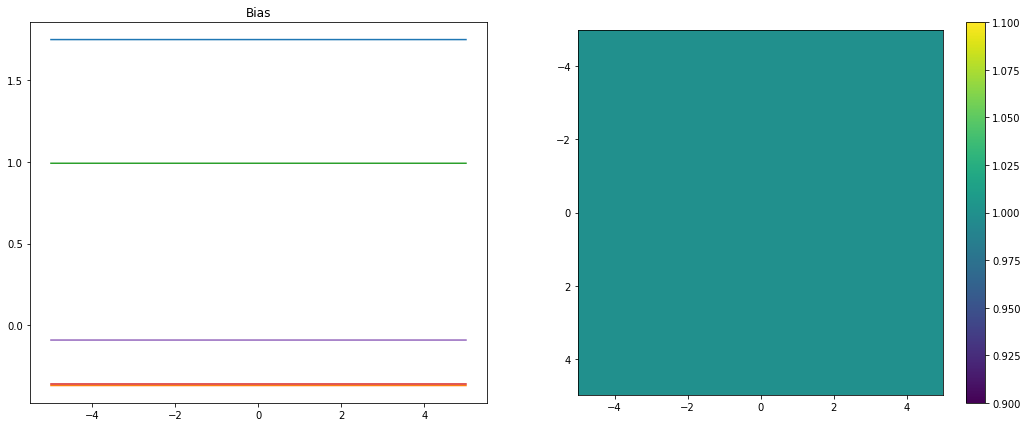

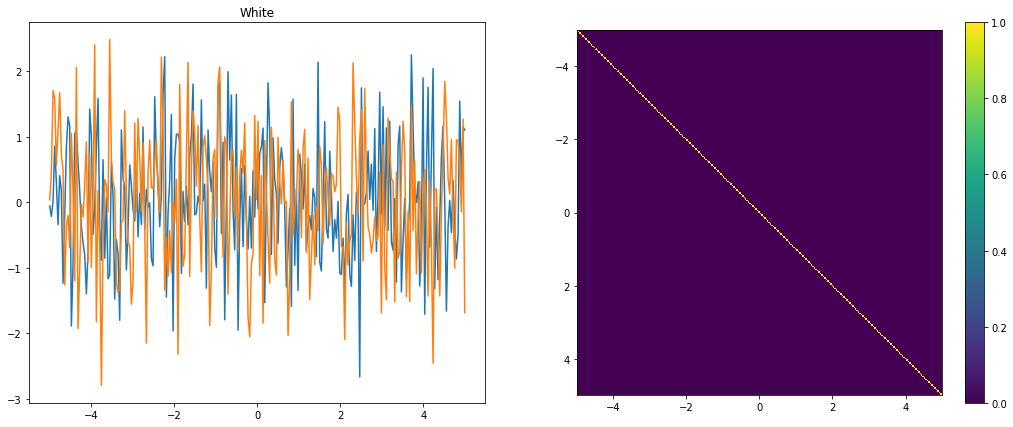

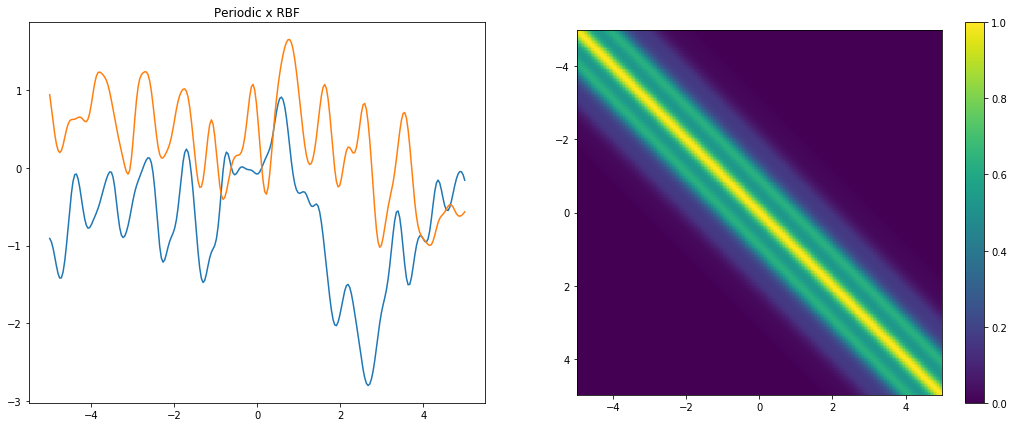

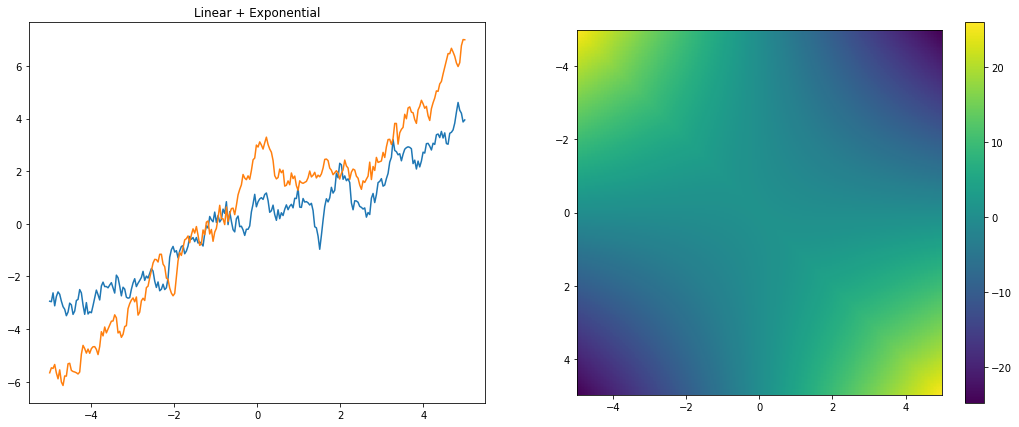

In [7]:
# This specific block of code is from GPSS 2018 Lab 1: http://gpss.cc/gpss18/labs
ks = [ # List of example kernels
    GPy.kern.RBF(1, lengthscale=1.),
    GPy.kern.RBF(1, lengthscale=0.5),
    GPy.kern.RBF(1, lengthscale=0.25, variance=2.),
    GPy.kern.Exponential(1),
    GPy.kern.Matern32(1),
    GPy.kern.Matern52(1),
    GPy.kern.StdPeriodic(1, period=2.),
    GPy.kern.Cosine(1),
    GPy.kern.Brownian(1),
    GPy.kern.Linear(1),
    GPy.kern.Bias(1),
    GPy.kern.White(1),
    GPy.kern.StdPeriodic(1)*GPy.kern.RBF(1),
    GPy.kern.Linear(1) + GPy.kern.Exponential(1)
]
# The name of our kernels (for the legend)
kernel_name = ["RBF ls=1", "RBF ls=0.5", "RBF ls=0.25, var=2", "Exponential", "Matern 3/2", 
               "Matern 5/2", "Periodic", "Cosine", "Brownian: $k(t, t^\prime) = a * min(t, t^\prime)$", "Linear", "Bias", "White", "Periodic x RBF", "Linear + Exponential"]

# Our sample space - note the [:, None] notation is a "shorthand" way to take
# a dimensionless array and make it n x 1
X = np.linspace(-5., 5., 250)[:, None]

print("The following plots demonstrate samples from a Gaussian process prior and the corresponding covariance matrix")

# Loop through our kernels
for i,k in enumerate(ks):
    # The mean function is set to 0
    mu = np.zeros((250)) # we have 250 sample inputs
    # Get the covariance matrix
    if i is not 11:
        C  = k.K(X,X)
    else: # We have to sample White noise kernel differently
        C = k.K(X)
        
    # Sample 5 times from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
    Z  = np.random.multivariate_normal(mu, C, 5)
    
    # Setup figure environment
    plt.figure(figsize=(18, 7))
    
    # Show samples on left hand side
    plt.subplot(121)
    for j in range(5 if i < 11 else 2): # Loop through samples
        plt.plot(X[:],Z[j,:])
        plt.title(kernel_name[i])
        
    # Visualise covariance matrix on right hand side
    plt.subplot(122)
    plt.pcolor(X.T, X, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

And to get our hands a bit dirtier, why don't we try coding up the GP prior with an RBF kernel from scratch
1. Hints start by creating a radial basis kernel function
2. `np.meshgrid` and `np.random.multivariate_normal(mean, kernel, number_of_samples)` will help

In [11]:
def rbf_kernel(x, gamma):
    m, n = np.meshgrid(x, x)
    return np.exp(-gamma * (m - n) ** 2)

In [12]:
N = 100
x = np.linspace(-np.pi, np.pi*3/4, N)[:,None]
K_rbf = rbf_kernel(x, gamma=1)
mean_rbf = [0]*K_rbf.shape[0]
data = np.random.multivariate_normal(mean_rbf, K_rbf, 5)

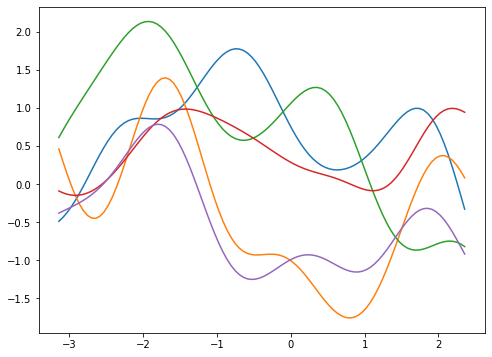

In [13]:
plt.figure(figsize=(8, 6))
for i in range(data.shape[0]):
    plt.plot(x, data[i, ])

 1. Generate the function that we will use for our exercises.
 $$f(x) = sin(2x)+0.2x$$ $$y = f(x)+\epsilon$$
 2. Generate some example data for the function

0
1
4558545735.370782
0
1
4559396806.199758
0
1
4570608920.845884
0
1
4544696292.495313
0
1
4568788728.1907835
0
1
4537628773.41834
0
1
4603892598.107255
0
1
4605659539.875027
0
1
4598114532.910886
0
1
4633361514.125139
0
1
4578665627.043318
0
1
4658360822.584981
0
1
4637392215.476447
0
1
4581370436.606081
0
1
4566580024.955045
0
1
4448170863.381034
0
1
4299867691.256877
0
1
4291936108.8577914
0
1
4280104426.618575
0
1
4173351512.3289933
0
1
4082178576.42594
0
1
4009228463.1994934
0
1
3908267860.196178
0
1
3825650643.9363594
0
1
3714735166.6959844
0
1
3575520618.1049933
0
1
3386130508.928208
0
1
3533881835.627282
0
1
3519302126.001571
0
1
3604582974.5064387
0
1
3816028558.011033
0
1
3635372531.9734244
0
1
3529308455.433376
0
1
3354295363.0529294
0
1
3205620912.3807573
0
1
3043310070.0084763
0
1
2804040335.409261
0
1
2601348134.2342935
0
1
2559315702.5560365
0
1
2614712379.643567
0
1
2459062378.872306
0
1
2313415579.4165483
0
1
2389106706.959484
0
1
2328507203.8884063
0
1
2153091168.930

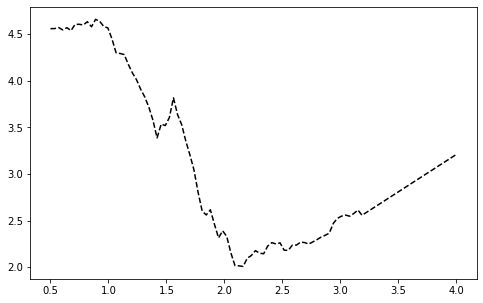

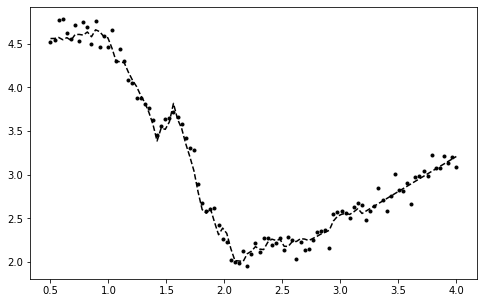

In [14]:
## the function we're going to use
#f = lambda xi: np.sin(xi * 2) + .2*xi
def f(x):
    returnarray = np.zeros(x.shape)
    for i, xi in enumerate(x):
        returnarray[i,0] = objective2(np.ones(8)*xi)/1e9
    return returnarray
#f = lambda xi: objective2(np.ones(8)*xi)/1e9


# sampling space
N = 100
#X_grid = np.linspace(-np.pi, np.pi*3/4, N)[:,None]
X_grid = np.linspace(0.5, 4.0, N)[:,None]
Y_grid = f(X_grid)
print(X_grid.shape)
print(Y_grid.shape)

# Show function
FIGSIZE = (8, 5)
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')

# Show function with noise
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')
plt.plot(X_grid, Y_grid + np.random.normal(0., .1, X_grid.shape) ,'k.')

0
1
4558545735.370782
0
1
4559396806.199758
0
1
4570608920.845884
0
1
4544696292.495313
0
1
4568788728.1907835
0
1
4537628773.41834
0
1
4603892598.107255
0
1
4605659539.875027
0
1
4598114532.910886
0
1
4633361514.125139
0
1
4578665627.043318
0
1
4658360822.584981
0
1
4637392215.476447
0
1
4581370436.606081
0
1
4566580024.955045
0
1
4448170863.381034
0
1
4299867691.256877
0
1
4291936108.8577914
0
1
4280104426.618575
0
1
4173351512.3289933
0
1
4082178576.42594
0
1
4009228463.1994934
0
1
3908267860.196178
0
1
3825650643.9363594
0
1
3714735166.6959844
0
1
3575520618.1049933
0
1
3386130508.928208
0
1
3533881835.627282
0
1
3519302126.001571
0
1
3604582974.5064387
0
1
3816028558.011033
0
1
3635372531.9734244
0
1
3529308455.433376
0
1
3354295363.0529294
0
1
3205620912.3807573
0
1
3043310070.0084763
0
1
2804040335.409261
0
1
2601348134.2342935
0
1
2559315702.5560365
0
1
2614712379.643567
0
1
2459062378.872306
0
1
2313415579.4165483
0
1
2389106706.959484
0
1
2328507203.8884063
0
1
2153091168.930

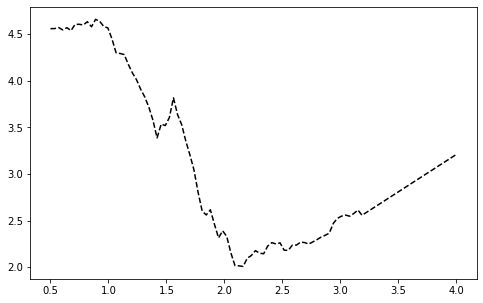

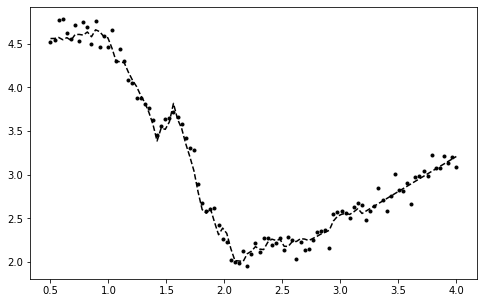

In [14]:
## the function we're going to use
#f = lambda xi: np.sin(xi * 2) + .2*xi
def f(x):
    returnarray = np.zeros(x.shape)
    for i, xi in enumerate(x):
        returnarray[i,0] = objective2(np.ones(8)*xi)/1e9
    return returnarray
#f = lambda xi: objective2(np.ones(8)*xi)/1e9


# sampling space
N = 10
#X_grid = np.linspace(-np.pi, np.pi*3/4, N)[:,None]
X_grid = np.linspace(0.5, 4.0, N)[:,None]
Y_grid = f(X_grid)
print(X_grid.shape)
print(Y_grid.shape)

# Show function
FIGSIZE = (8, 5)
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')

# Show function with noise
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')
plt.plot(X_grid, Y_grid + np.random.normal(0., .1, X_grid.shape) ,'k.')

0
1
4558545735.370782
0
1
4559396806.199758
0
1
4570608920.845884
0
1
4544696292.495313
0
1
4568788728.1907835
0
1
4537628773.41834
0
1
4603892598.107255
0
1
4605659539.875027
0
1
4598114532.910886
0
1
4633361514.125139
0
1
4578665627.043318
0
1
4658360822.584981
0
1
4637392215.476447
0
1
4581370436.606081
0
1
4566580024.955045
0
1
4448170863.381034
0
1
4299867691.256877
0
1
4291936108.8577914
0
1
4280104426.618575
0
1
4173351512.3289933
0
1
4082178576.42594
0
1
4009228463.1994934
0
1
3908267860.196178
0
1
3825650643.9363594
0
1
3714735166.6959844
0
1
3575520618.1049933
0
1
3386130508.928208
0
1
3533881835.627282
0
1
3519302126.001571
0
1
3604582974.5064387
0
1
3816028558.011033
0
1
3635372531.9734244
0
1
3529308455.433376
0
1
3354295363.0529294
0
1
3205620912.3807573
0
1
3043310070.0084763
0
1
2804040335.409261
0
1
2601348134.2342935
0
1
2559315702.5560365
0
1
2614712379.643567
0
1
2459062378.872306
0
1
2313415579.4165483
0
1
2389106706.959484
0
1
2328507203.8884063
0
1
2153091168.930

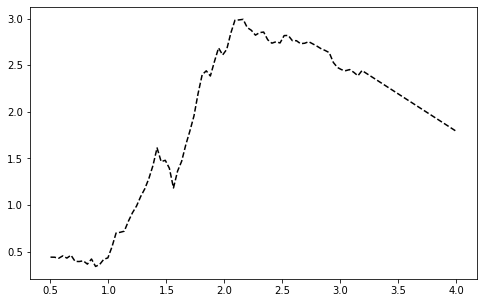

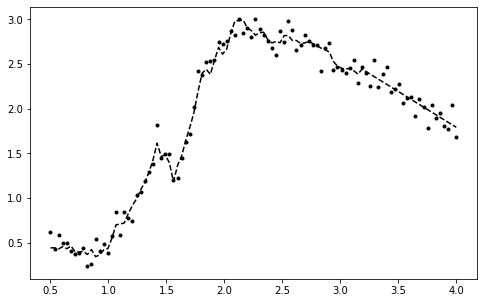

In [39]:
## the function we're going to use
#f = lambda xi: np.sin(xi * 2) + .2*xi
def f(x):
    returnarray = np.zeros(x.shape)
    for i, xi in enumerate(x):
        returnarray[i,0] = 5.0 - objective2(np.ones(8)*xi)/1e9
    return returnarray
#f = lambda xi: objective2(np.ones(8)*xi)/1e9


# sampling space
N = 100
#X_grid = np.linspace(-np.pi, np.pi*3/4, N)[:,None]
X_grid = np.linspace(0.5, 4.0, N)[:,None]
Y_grid = f(X_grid)
print(X_grid.shape)
print(Y_grid.shape)

# Show function
FIGSIZE = (8, 5)
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')

# Show function with noise
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')
plt.plot(X_grid, Y_grid + np.random.normal(0., .1, X_grid.shape) ,'k.')

Lets sample 5 data points and fit a GP to the data.

0
4006430951.8501625
0
2294653165.4458895
0
2625608476.932421
0
2699739885.920214
0
4687826977.700727
0
2071591289.3110216
0
2237183095.9033165
0
2287201004.11709
0
2934691985.169864
0
3192098900.197864

Name : GP regression
Objective : 1.3412534027061405
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    3.4795633253942273  |      +ve      |        
  rbf.lengthscale          |    1.4359249641097311  |      +ve      |        
  Gaussian_noise.variance  |  0.006393107409170726  |      +ve      |        


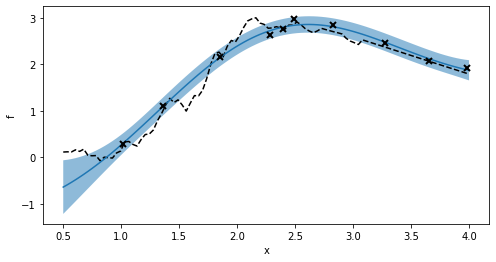

In [14]:
# we sample the function and look at GP prediction
# Sample from the function
# Number of samples 
num_measurements = 10

# Random sample locations
X_samples = np.random.uniform(0.5, 4.0, (num_measurements, 1))

# Get the function value with noise
Y_samples = f(X_samples) + np.random.normal(0., .1, (X_samples.shape[0],1))

# Set up the kernel and the GP model
k = GPy.kern.RBF(1, lengthscale=1)
m = GPy.models.GPRegression(X_samples, Y_samples, k)

# optimize hyperparameters
m.optimize('bfgs', max_iters=100)
    
# Identify the mean and covariance of the GP fit over the grid
mean, Cov = m.predict(X_grid, full_cov=True)

# Plot the generating curve and the GP
plt.figure(figsize = (8,4))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
print(m)

We can now sample the GP given our measured data points:

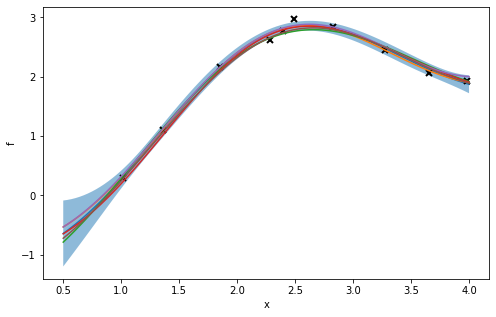

In [15]:
mean, Cov = m.predict_noiseless(X_grid, full_cov=True)
Z  = np.random.multivariate_normal(mean.ravel(), Cov, 5).T
plt.figure(figsize = FIGSIZE)
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
plt.plot(X_grid,Z);

Some things to remember:
* GP will tend toward the mean as it gets further from the given data.
  * Often the mean is assumed to be zero, is this best for your challenge?
* Hyperparameter optimization
  * GP uses hyperparameters, e.g. the squared exponential kernel:
  $k(x,x')=A exp(-(x-x')^2/2L^2)$
  *$->$ Amplitude A and lengthscale L
  * Optimize: m.optimize('bfgs', max_iters=100)
  * Check your results: print(m)

### Active Learning Bayesian Optimization:
Need:
* $f(x)$ Model to represent data as it comes in.
* $\alpha(x)$ aquisition function to quantify desirablity of performing each experiment.

### Bayesian Optimization, Approach 1: Exploiting Prior Knowledge  
1. Fit a GP to the data
2. Identify the GP mean
3. Find the maximum of the GP mean

In [16]:
# We're going to use the GP in the same way multiple times, so let's create a function
def GP_analysis(X, Y, X_grid):
    # Use GP regression to fit the data
    k = GPy.kern.RBF(1)
    m = GPy.models.GPRegression(X, Y, k)
    m.optimize('bfgs', max_iters=100)
    
    # Predict the mean and covariance of the GP fit over the grid
    mean, Cov = m.predict(X_grid, full_cov=True)
    variance = np.diag(Cov)
    return mean, Cov, variance, m


# We will also plot the Bayesian Optimization results multiple times, so let's create a function too:
def plot_BO_results(X_grid, Y_grid, mean, Cov, alpha_full, X_samples, Y_samples, next_sample, true_max_x, true_max_y):
    plt.figure(figsize = FIGSIZE)
    plt.subplot(2,1,1)
    plt.plot(X_grid, Y_grid,'k--')
    plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
    plt.plot([X_grid[next_sample], X_grid[next_sample]],[-1.5, 1.5],'m')
    plt.plot(true_max_x, true_max_y, 'ro')

    plt.subplot(2,1,2)
    plt.plot(X_grid, alpha_full,'r')
    plt.plot([X_grid[next_sample], X_grid[next_sample]],[0, np.max(alpha_full)],'m')
    plt.title('Aquisition function')

0
2894850661.9623084
0
4834877968.934624
0
2634188225.459553
0
2241742678.2232814
0
2281285885.963047


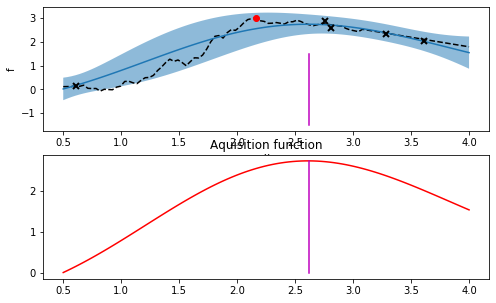

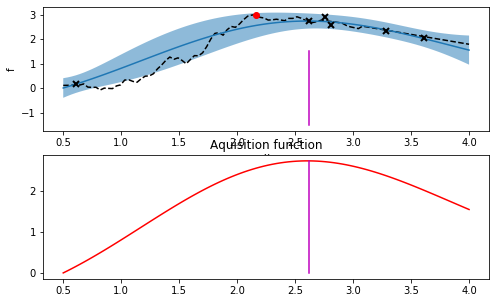

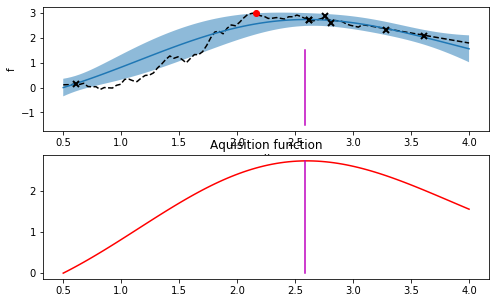

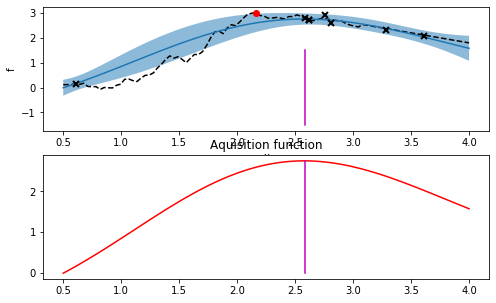

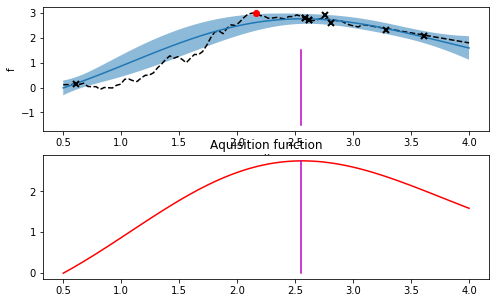

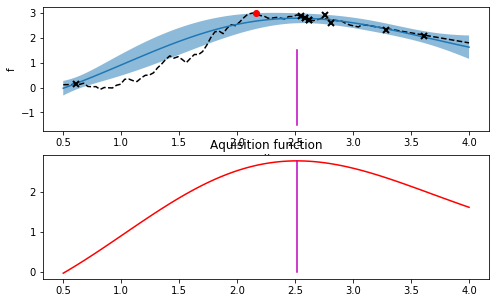

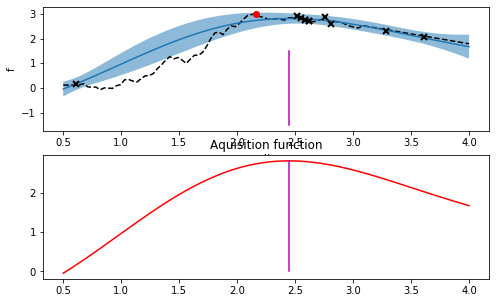

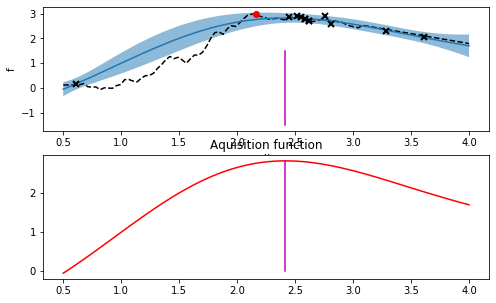

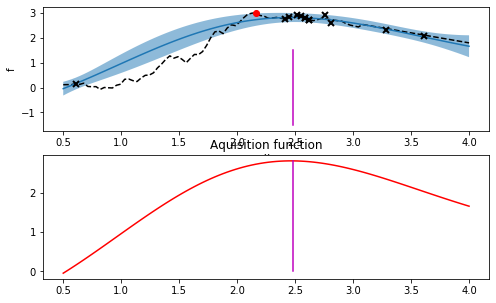

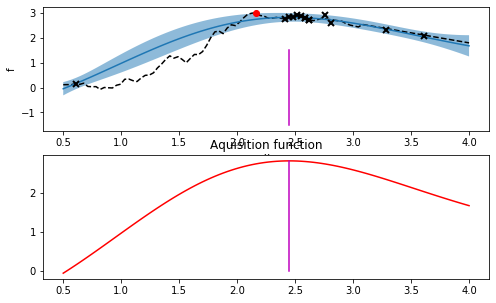

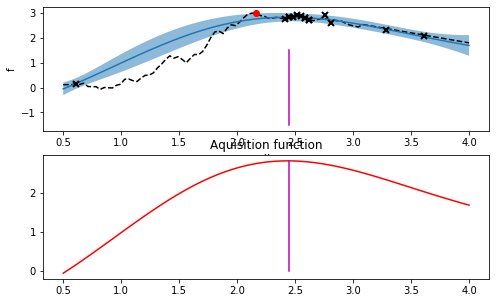

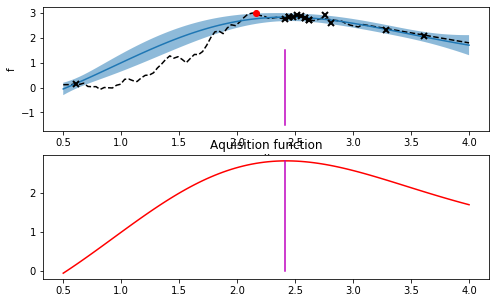

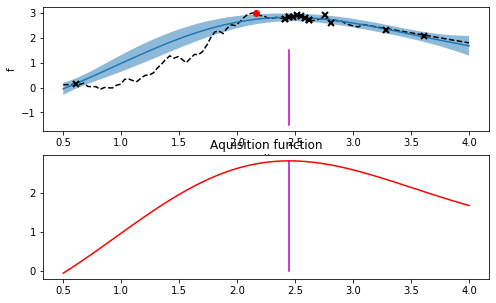

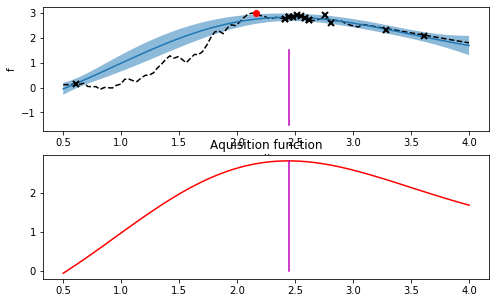

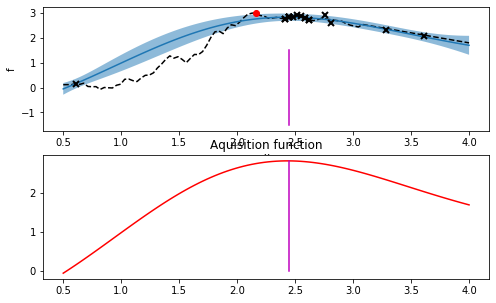

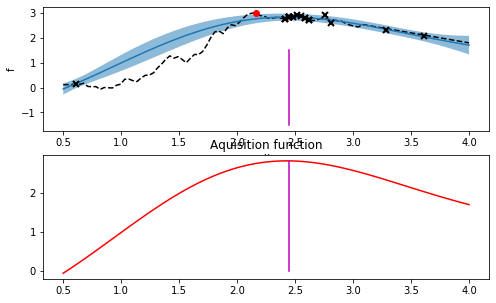

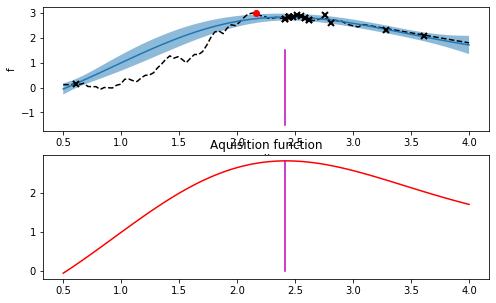

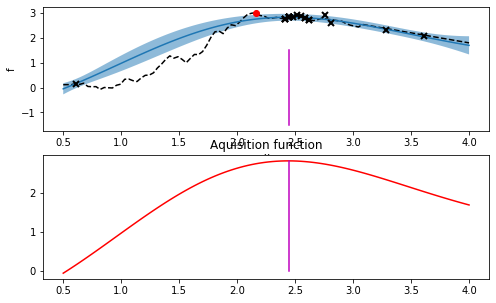

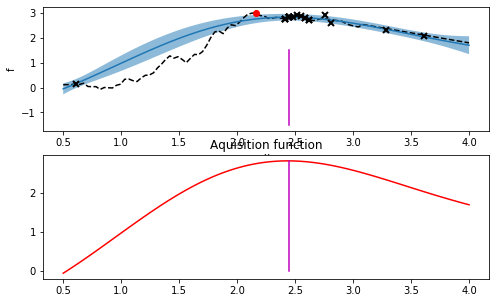

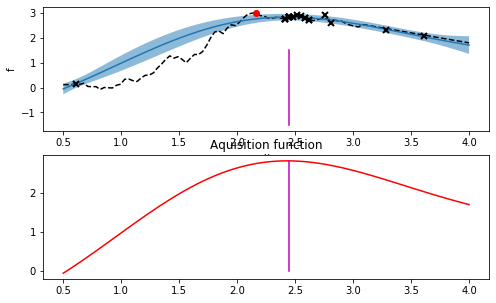

In [17]:
# BO by maximizing mean
num_measurements = 5
Number_of_iterations = 20

# The value (y) and position (x) of the true max
true_max_y = np.max(Y_grid)
true_max_x = X_grid[np.argmax(Y_grid)]

# Random sample locations
X_samples = np.random.uniform(0.5, 4.0, (num_measurements, 1))

# Get the function value with noise
Y_samples = f(X_samples) + np.random.normal(0., .1, (X_samples.shape[0],1))

# We will use this matrix to store the GP mean at every iteration.
Y_estimates = np.full((len(X_grid),Number_of_iterations),np.nan)

for i in range(0, Number_of_iterations):
    
    # Use GP regression to fit the data
    mean, Cov, variance, m = GP_analysis(X_samples, Y_samples, X_grid)
    
    # find the x value where the GP reaches a maximum
    alpha_full = mean
    next_sample_index = np.argmax(alpha_full)
    
    # This plots the objective function, with a magneta line where we want to sample next.
    # The red dot shows where the maximum is.
    plot_BO_results(X_grid, Y_grid, mean, Cov, alpha_full, X_samples, Y_samples, next_sample_index, true_max_x, true_max_y)
    
    # add the desired sample to our data
    X_samples = np.vstack((X_samples,X_grid[next_sample_index,:]))
    Y_samples = np.vstack((Y_samples,Y_grid[next_sample_index,0]))
    
    # Store the GP mean for this iteration.
    Y_estimates[:,i] = mean.ravel()

To quantify how well this method works at finding the maximum, we will compute the minimum regret.
<br>This method **assumes that we know the correct answer**.

Text(0.5, 0, 'Iteration Number')

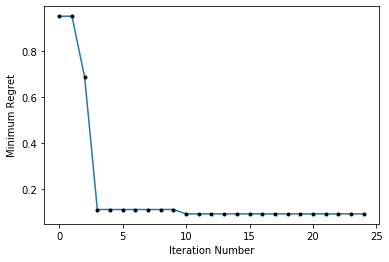

In [18]:
# This function computes the minimum regret.
# It takes as input:
# 1. The samples that have been measured, in the order that they were measured
# 2. The maximum
# It outputs the minimum regret at every iteration.
def calc_min_regret(Y_samples, Y_max):
    min_regret = Y_max - np.maximum.accumulate(Y_samples)
    return min_regret

# Calculate the minimum regret for out previous exercise
min_regret = calc_min_regret(Y_samples,Y_grid.max())

# Plot the minimum regret as a function of iteration number.
plt.figure()
plt.plot(range(0,len(Y_samples)),min_regret)
plt.plot(range(0,len(Y_samples)),min_regret,'k.')
plt.ylabel('Minimum Regret')
plt.xlabel('Iteration Number')

Let's quantify how well the previous exercise did at identifying the full function.
<br>For this we will use Root Mean Square Error (RMSE) between the predicted function values, given by the GP mean, and the true function values.

Text(0.5, 0, 'Iteration Number')

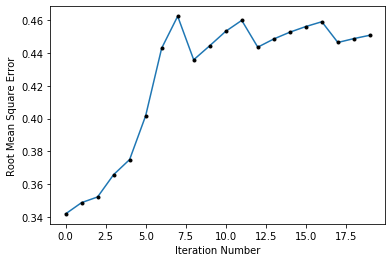

In [19]:
# Now lets look at how well this method works at identifying the function
# Calculates the Root Mean Square Error at each iteration.
def calc_rmse(Y_estimates, Y_grid):
    residuals_squared = np.square( Y_estimates - np.tile(Y_grid,(1,Y_estimates.shape[1])) )
    rmse = np.sqrt( np.mean( residuals_squared, axis = 0) )
    return rmse
    
# Plot the RMSE
rmse = calc_rmse(Y_estimates, Y_grid)
plt.figure()
plt.plot(range(0, Number_of_iterations), rmse)
plt.plot(range(0, Number_of_iterations), rmse,'k.')
plt.ylabel('Root Mean Square Error')
plt.xlabel('Iteration Number')   

If we don't know the correct answer in either case (the true maximum, or the true underlying function) we can instead look at convergence.

Text(0.5, 1.0, 'Y values')

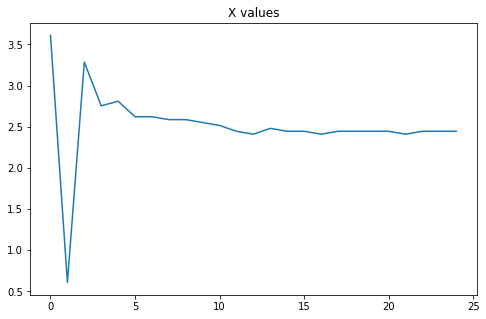

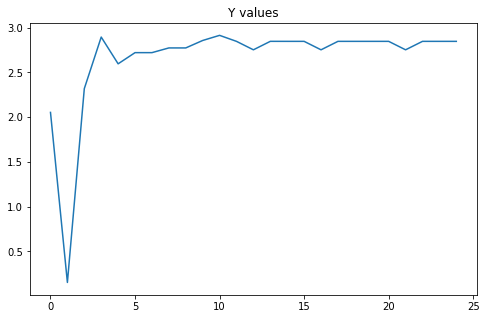

In [20]:
plt.figure(figsize = FIGSIZE)
plt.plot(X_samples)
plt.title('X values')

plt.figure(figsize = FIGSIZE)
plt.plot(Y_samples)
plt.title('Y values')

Convergence for identifying the true curve

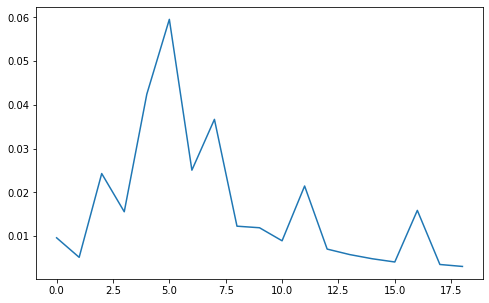

In [21]:
def calc_function_convergence_using_RMSE(Y_estimates):
    rmse_ = np.sqrt( np.mean( np.square( np.diff(Y_estimates, axis = 1) ), axis = 0 ) )
    return rmse_

rmse_ = calc_function_convergence_using_RMSE(Y_estimates)

plt.figure(figsize = FIGSIZE)
plt.plot(rmse_)

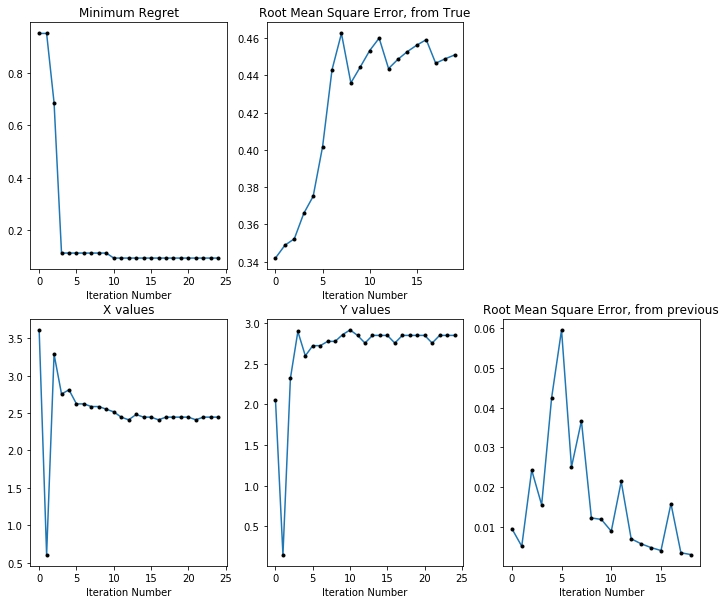

In [22]:
def plot_BO_metrics(Y_samples, Y_grid, Y_estimates):
    
    min_regret = calc_min_regret(Y_samples,Y_grid.max())
    rmse = calc_rmse(Y_estimates, Y_grid)
    rmse_ = calc_function_convergence_using_RMSE(Y_estimates)

    plt.figure(figsize = (12,10))
    plt.subplot(2,3,1)
    plt.plot(range(0,len(Y_samples)),min_regret)
    plt.plot(range(0,len(Y_samples)),min_regret,'k.')
    plt.title('Minimum Regret')
    plt.xlabel('Iteration Number')

    plt.subplot(2,3,2)
    plt.plot(range(0, len(rmse)), rmse)
    plt.plot(range(0, len(rmse)), rmse,'k.')
    plt.title('Root Mean Square Error, from True')
    plt.xlabel('Iteration Number') 
    
    plt.subplot(2,3,4)
    plt.plot(range(0,len(Y_samples)),X_samples)
    plt.plot(range(0,len(Y_samples)),X_samples,'k.')
    plt.title('X values')
    plt.xlabel('Iteration Number')

    plt.subplot(2,3,5)
    plt.plot(range(0,len(Y_samples)),Y_samples)
    plt.plot(range(0,len(Y_samples)),Y_samples,'k.')
    plt.title('Y values')
    plt.xlabel('Iteration Number')
    
    plt.subplot(2,3,6)
    plt.plot(range(0, len(rmse_)), rmse_)
    plt.plot(range(0, len(rmse_)), rmse_,'k.')
    plt.title('Root Mean Square Error, from previous')
    plt.xlabel('Iteration Number') 
    
plot_BO_metrics(Y_samples, Y_grid, Y_estimates)

Now let's try exploring instead of exploiting. We're going to select the point with the maximum variance.

0
4833942331.583338


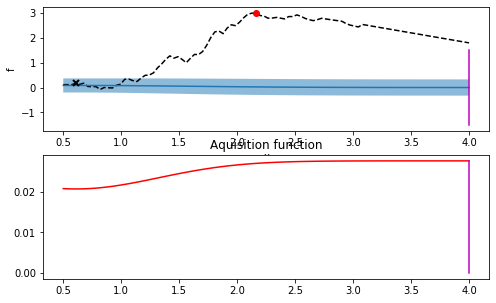

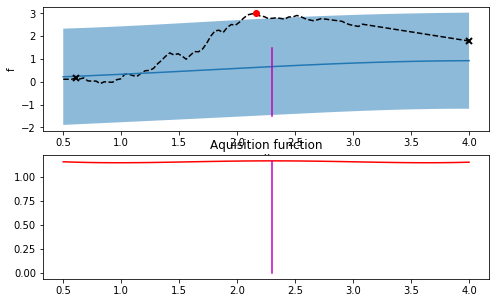

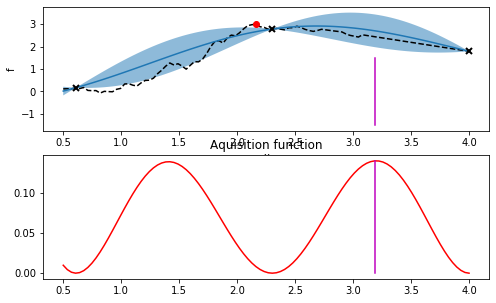

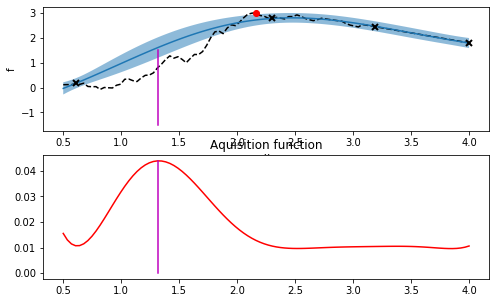

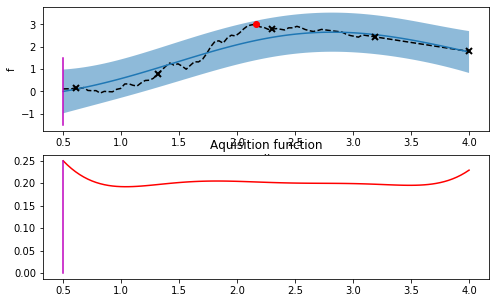

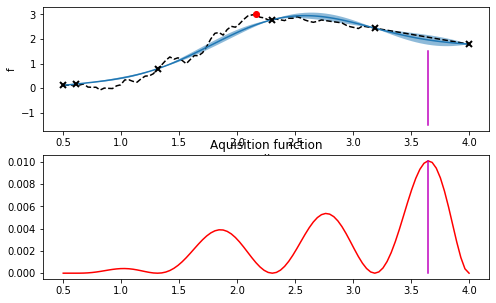

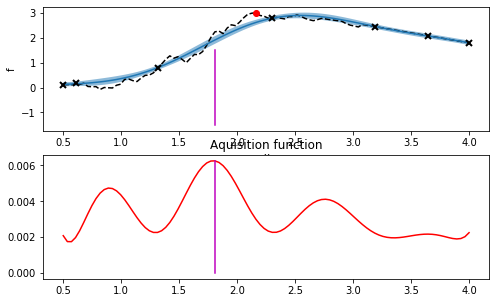

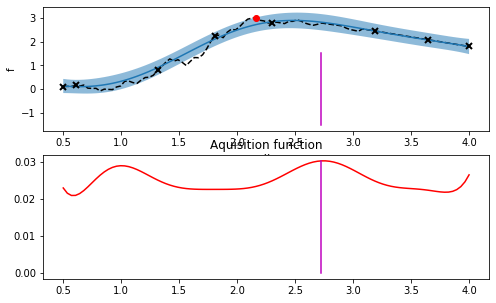

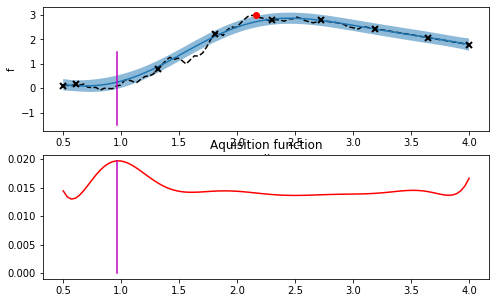

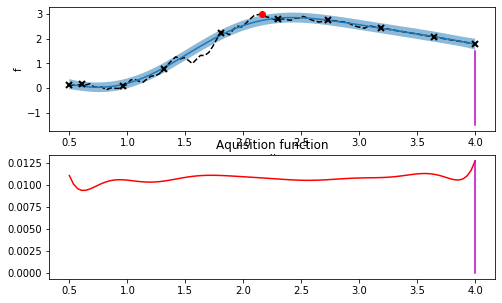

In [23]:
# Number of samples 
num_measurements = 1

# Random sample locations
X_samples = np.random.uniform(0.5, 4.0, (num_measurements, 1))

# Get the function value
Y_samples = f(X_samples) 

for i in range(0, 10):
    
    # Use GP regression to fit the data
    mean, Cov, variance, m = GP_analysis(X_samples, Y_samples, X_grid)
    
    # find the sample 
    alpha_full = variance
    next_sample_index = np.argmax(alpha_full)   # <------ the variance is the aquisition function
    
    # This plots the objective function, with magenta where we want to sample next.
    # Red X dot for global maximum
    plot_BO_results(X_grid, Y_grid, mean, Cov, alpha_full, X_samples, Y_samples, next_sample_index, true_max_x, true_max_y)
    
    # add the desired sample to our data
    X_samples = np.vstack((X_samples,X_grid[next_sample_index,:]))
    Y_samples = np.vstack((Y_samples,Y_grid[next_sample_index,0]))

Now we'll combine exploring and exploiting via Upper Confidence Bound

0
2250322560.755783
0
2593018611.292456
0
2524041261.8341146
0
2944373507.285777
0
4862075733.544237


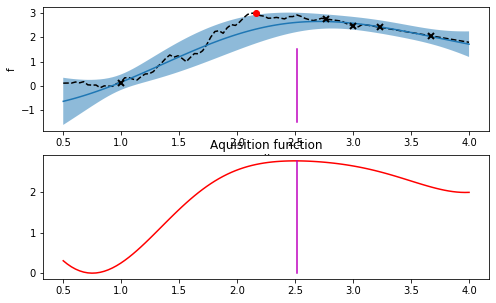

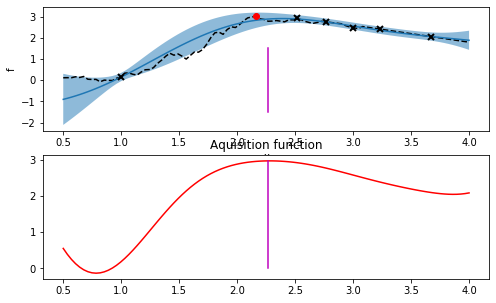

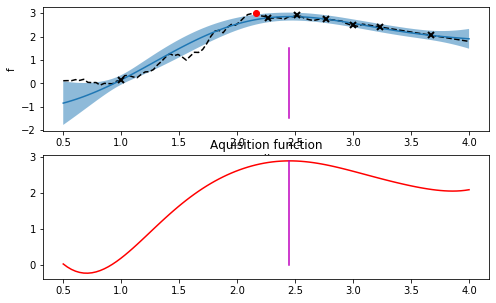

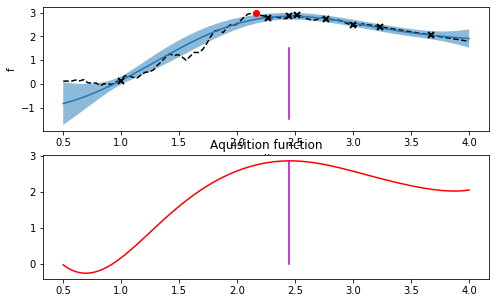

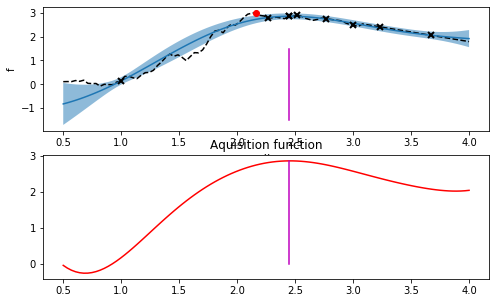

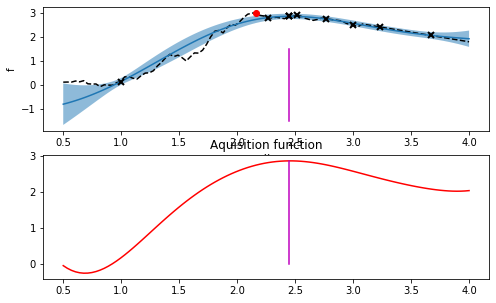

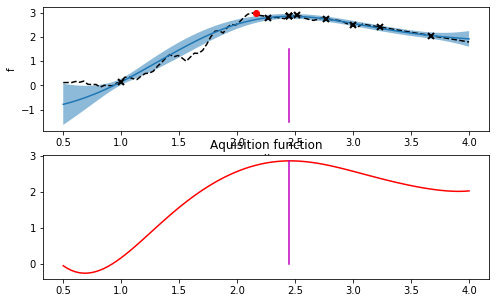

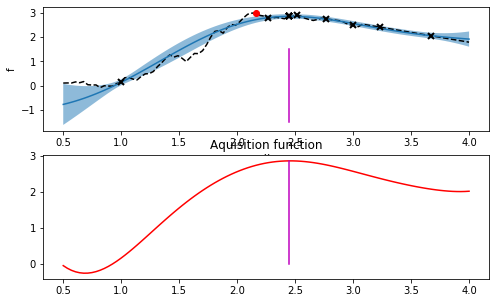

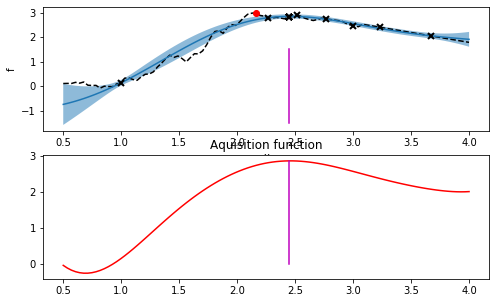

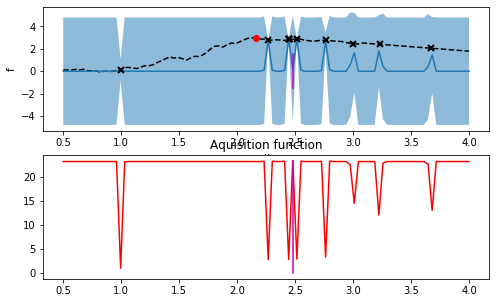

In [24]:
# Number of samples 
num_measurements = 5

Dsize = len(X_grid)
BO_lambda = .1
BO_number_of_iterations = 1

# Random sample locations
X_samples = np.random.uniform(0.5, 4.0, (num_measurements, 1))

# Get the function value
Y_samples = f(X_samples) 

for i in range(0, 10):
    
    # Use GP regression to fit the data
    mean, Cov, variance, m = GP_analysis(X_samples, Y_samples, X_grid)
    
    # Compute UCB
    BO_beta = 2 * math.log(Dsize * math.pow(BO_number_of_iterations,2) * math.pow(np.pi,2) / (6 * BO_lambda) )
    alpha_full = mean + math.sqrt(BO_beta) * variance[:,None]
        
    # Find the next sample   
    next_sample_index = np.argmax(alpha_full)
    
    # This plots the objective function, with yellow where we want to sample next.
    # Red X for global minimum, Red dots for the sample selected to be measured next
    plot_BO_results(X_grid, Y_grid, mean, Cov, alpha_full, X_samples, Y_samples, next_sample_index, true_max_x, true_max_y)
    
    # add the desired sample to our data
    X_samples = np.vstack((X_samples,X_grid[next_sample_index,:]))
    Y_samples = np.vstack((Y_samples,Y_grid[next_sample_index,0]))

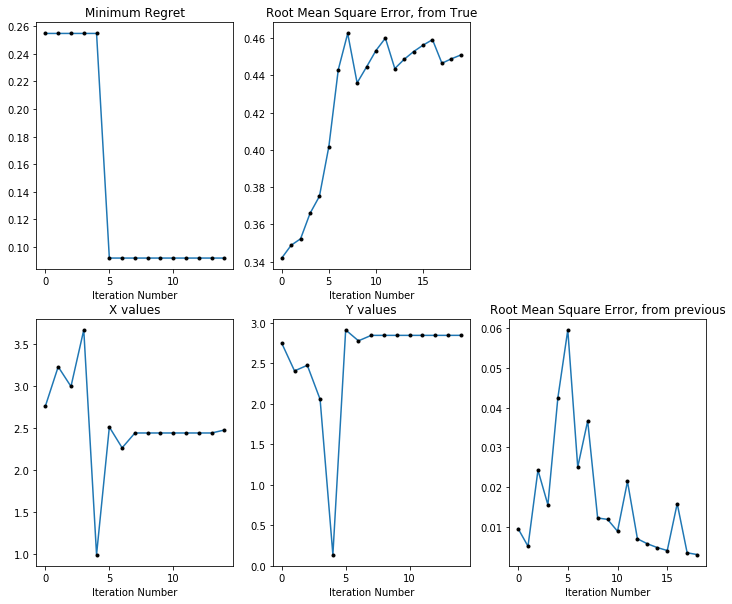

In [25]:
plot_BO_metrics(Y_samples, Y_grid, Y_estimates)

Thompson Sampling

0
2174382560.196527


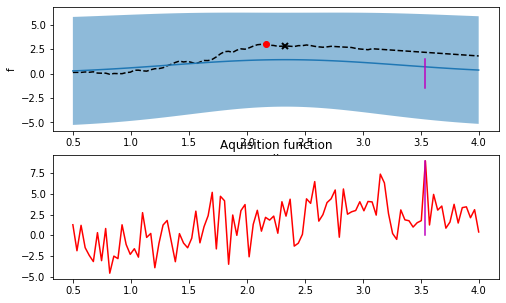

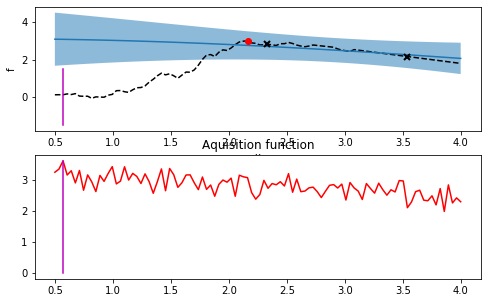

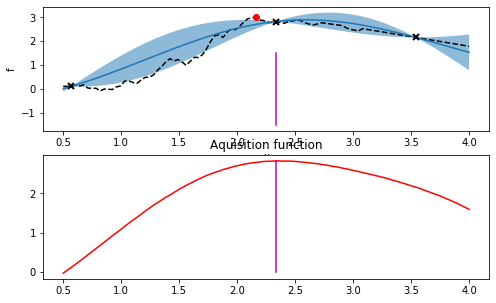

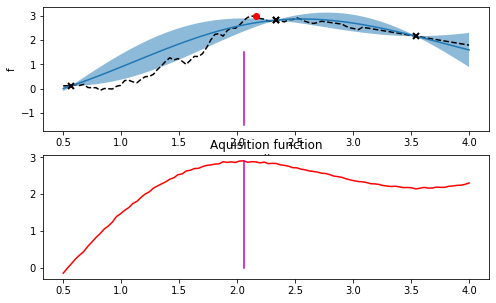

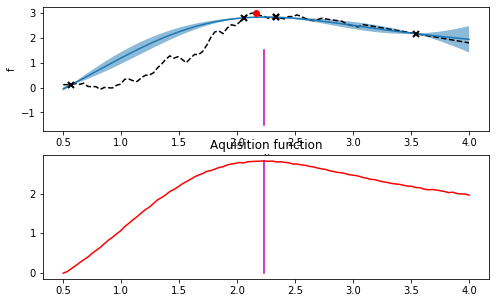

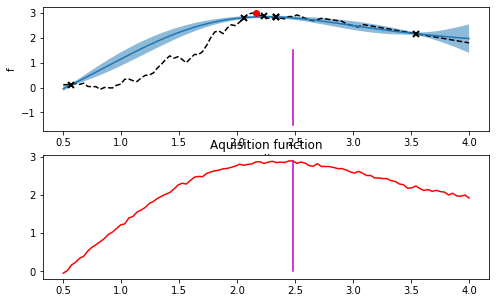

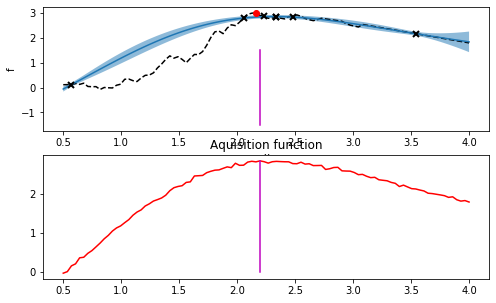

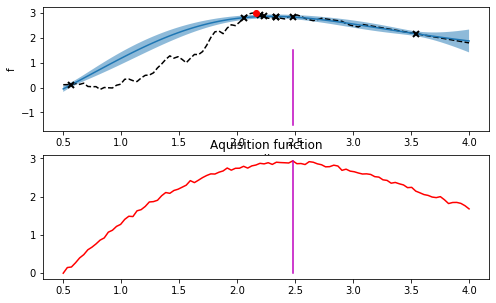

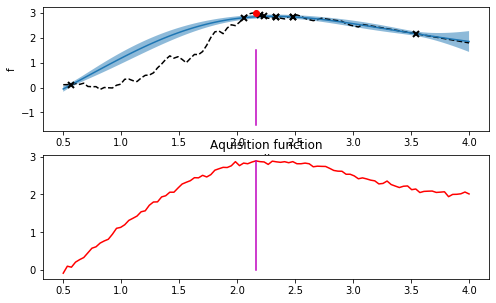

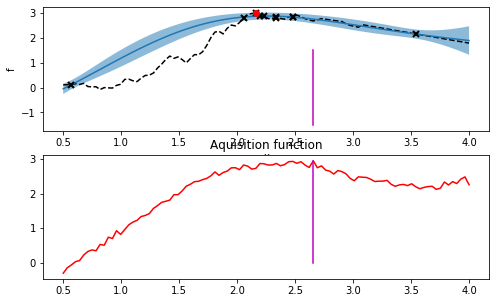

In [26]:
# Number of samples 
num_measurements = 1

# Random sample locations
X_samples = np.random.uniform(0.5, 4.0, (num_measurements, 1))

# Get the function value
Y_samples = f(X_samples) 

for i in range(0, 10):
    
    # Use GP regression to fit the data
    mean, Cov, variance, m = GP_analysis(X_samples, Y_samples, X_grid)
    
    # Sample the Gaussian Process!
    alpha_full  = np.random.multivariate_normal(mean.ravel(), Cov, 1).T
    next_sample_index = np.argmax(alpha_full)
    
    # This plots the objective function, with yellow where we want to sample next.
    # Red X for global minimum, Red dots for the sample selected to be measured next
    plot_BO_results(X_grid, Y_grid, mean, Cov, alpha_full, X_samples, Y_samples, next_sample_index, true_max_x, true_max_y)  
   
    # add the desired sample to our data
    X_samples = np.vstack((X_samples,X_grid[next_sample_index,:]))
    Y_samples = np.vstack((Y_samples,Y_grid[next_sample_index,0]))

BO-LCB using built in function
We're looking for the Minimum Now!

In [27]:
from GPyOpt.acquisitions import AcquisitionEI, AcquisitionLCB, AcquisitionMPI

0
2876221358.1224165


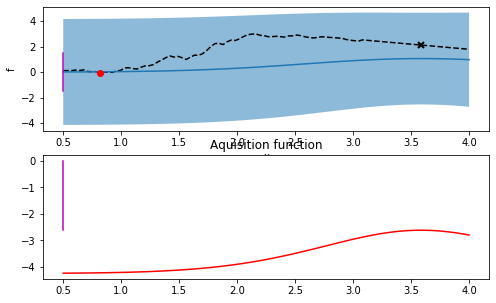

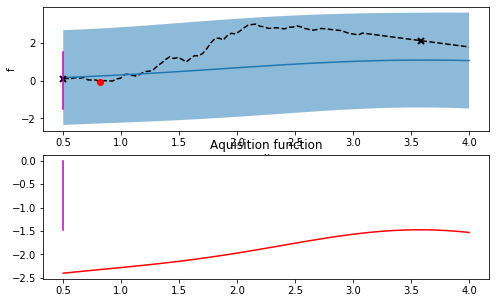

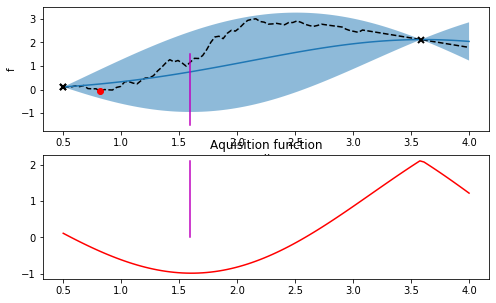

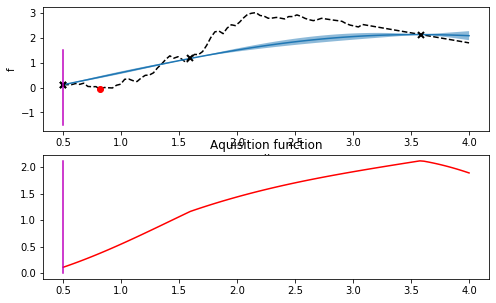

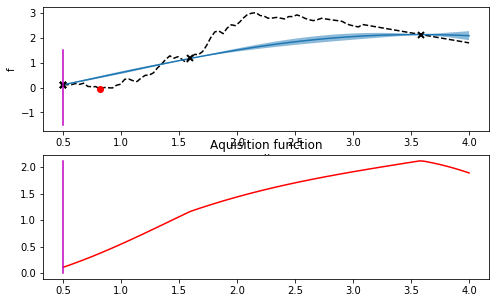

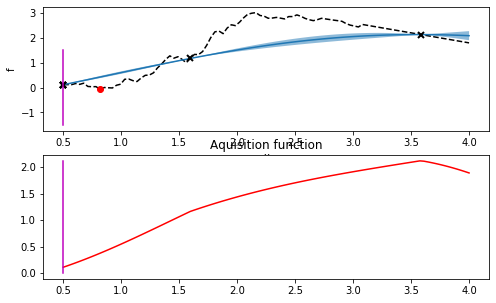

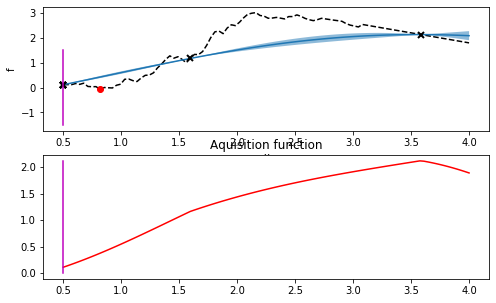

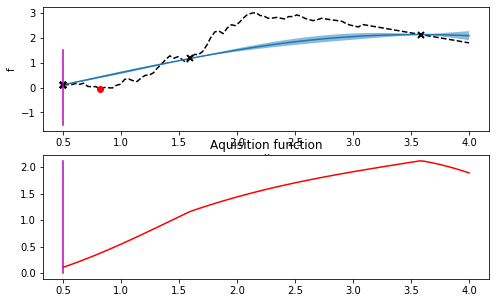

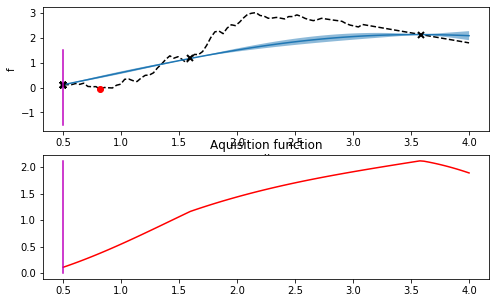

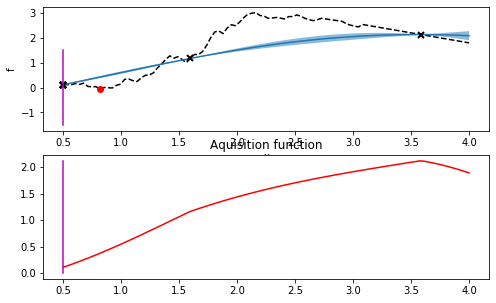

In [28]:
# The value (y) and position (x) of the true min
true_min_y = np.min(Y_grid)
true_min_x = X_grid[np.argmin(Y_grid)]

# Number of samples 
num_measurements = 1

# Random sample locations
X_samples = np.random.uniform(0.5, 4.0, (num_measurements, 1))

# Get the function value
Y_samples = f(X_samples)     # <-------------- Remember this is LCB

# Create the necessary variables
from GPyOpt import Design_space  ## GPyOpt design space
space = Design_space([{'name': 'var_1', 'type': 'continuous', 'domain': (0.5, 4.0)}] )
from GPyOpt.models import GPModel

for i in range(0, 10):
    
    # Use GP regression to fit the data
    mean, Cov, variance, m = GP_analysis(X_samples, Y_samples, X_grid)
    model = GPModel(optimize_restarts=1,verbose=False)
    model.model = m
    
    # find the sample 
    acq_LCB = AcquisitionLCB(model,space,exploration_weight = 2) # <------------ Beta is a constant = 2
    alpha_full = acq_LCB.acquisition_function(X_grid)
    next_sample_index = np.argmin(alpha_full)
    
    # This plots the objective function, with yellow where we want to sample next.
    # Red X for global minimum, Red dots for the sample selected to be measured next
    plot_BO_results(X_grid, Y_grid, mean, Cov, alpha_full, X_samples, Y_samples, next_sample_index, true_min_x, true_min_y)    
    
    # add the desired sample to our data
    X_samples = np.vstack((X_samples,X_grid[next_sample_index,:]))
    Y_samples = np.vstack((Y_samples, Y_grid[next_sample_index,0]))

Due to the stochasticity of our active learning methods, we want to see performance over multiple runs. Let's look at performance over 10 runs.

In [29]:
# BO by maximizing mean
number_of_measurements = 3
number_of_repetitions = 10
number_of_iterations = 40
queries_ALmean_ = np.empty((number_of_repetitions, number_of_iterations + number_of_measurements))
rmse_ALmean_ = np.empty((number_of_repetitions,number_of_iterations))
for j in range(0, number_of_repetitions):
    
    # Random sample locations
    X_samples = np.random.uniform(0.5, 4.0, (number_of_measurements, 1))

    # Get the function value with noise
    Y_samples = f(X_samples) + np.random.normal(0., .1, (X_samples.shape[0],1))

    # We will use this matrix to store the GP mean at every iteration.
    Y_estimates = np.full((len(X_grid), number_of_iterations),np.nan)
    
    # store the randomly sampled data
    queries_ALmean_[j,0:3] = Y_samples.ravel()
    
    for i in range(0, number_of_iterations):
    
        # Use GP regression to fit the data
        mean, Cov, variance, m = GP_analysis(X_samples, Y_samples, X_grid)
    
        # find the x value where the GP reaches a maximum
        alpha_full = mean
        next_sample_index = np.argmax(alpha_full)
    
        # add the desired sample to our data
        X_samples = np.vstack((X_samples,X_grid[next_sample_index,:]))
        Y_samples = np.vstack((Y_samples,Y_grid[next_sample_index,0]))
    
        # Store the GP mean for this iteration.
        Y_estimates[:,i] = mean.ravel()
        
        # Store the active learning sample
        queries_ALmean_[j,i+3] = Y_grid[next_sample_index,0]
    rmse_ALmean_[j,:] = calc_rmse(Y_estimates, Y_grid)

0
2072148781.2123334
0
4847281766.1547165
0
2799408699.255387
0
2292799975.464172
0
4397557243.748522
0
2319048856.233075
0
2313969186.5926075
0
4486676865.200719
0
2925349513.429164
0
2072708826.7274523
0
4887007292.680896
0
2771576358.3171887
0
2602324397.196176
0
2871458636.741908
0
2011571516.3795166
0
4811776015.014972
0
2550093107.1173167
0
2519420818.3586555
0
3798419540.995146
0
2982430962.0767174
0
2677263310.022232
0
2596724404.092511
0
2456195761.3496265
0
4489676137.323573
0
2518345509.1030455
0
4842586735.862191
0
4792629994.637552
0
2091044439.427632
0
4956725804.292513
0
3094863054.7925286


Text(0.5, 1.0, 'Avg of RMSE over runs')

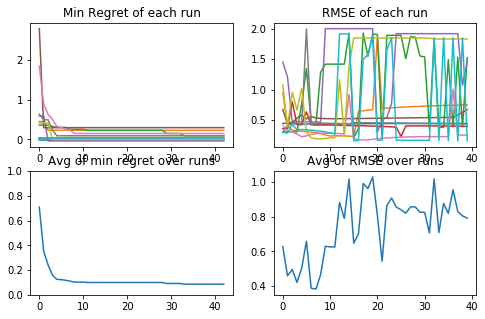

In [30]:
minregret_ALmean_ = np.empty(queries_ALmean_.shape)
for i in range(0, queries_ALmean_.shape[0]):
    minregret_ALmean_[i,:] = calc_min_regret(queries_ALmean_[i], Y_grid.max())  
    
plt.figure(figsize = FIGSIZE)
plt.subplot(2,2,1)
plt.plot(minregret_ALmean_.T)
plt.title('Min Regret of each run')
plt.subplot(2,2,3)
plt.plot(np.mean(minregret_ALmean_,axis = 0))
plt.title('Avg of min regret over runs')
plt.ylim((0,1))
plt.subplot(2,2,2)
plt.plot(rmse_ALmean_.T)
plt.title('RMSE of each run')
plt.subplot(2,2,4)
plt.plot(np.mean(rmse_ALmean_,axis = 0))
plt.title('Avg of RMSE over runs')

In [31]:
# BO by maximizing variance
number_of_measurements = 3
number_of_repetitions = 10
number_of_iterations = 40
queries_ALvar_ = np.empty((number_of_repetitions, number_of_iterations + number_of_measurements))
rmse_ALvar_ = np.empty((number_of_repetitions,number_of_iterations))

for j in range(0, number_of_repetitions):
    
    # Random sample locations
    X_samples = np.random.uniform(0.5, 4.0, (number_of_measurements, 1))

    # Get the function value with noise
    Y_samples = f(X_samples) + np.random.normal(0., .1, (X_samples.shape[0],1))

    # We will use this matrix to store the GP mean at every iteration.
    Y_estimates = np.full((len(X_grid), number_of_iterations),np.nan)
    
    # store the randomly sampled data
    queries_ALmean_[j,0:3] = Y_samples.ravel()
    
    for i in range(0, number_of_iterations):
    
        # Use GP regression to fit the data
        mean, Cov, variance, m = GP_analysis(X_samples, Y_samples, X_grid)
    
        # find the x value where the GP reaches a maximum
        alpha_full = variance
        next_sample_index = np.argmax(alpha_full)
    
        # add the desired sample to our data
        X_samples = np.vstack((X_samples,X_grid[next_sample_index,:]))
        Y_samples = np.vstack((Y_samples,Y_grid[next_sample_index,0]))
    
        # Store the GP mean for this iteration.
        Y_estimates[:,i] = mean.ravel()
        
        # Store the active learning sample
        queries_ALvar_[j,i+3] = Y_grid[next_sample_index,0]
    rmse_ALvar_[j,:] = calc_rmse(Y_estimates, Y_grid)

0
4728469468.543987
0
4004625132.422012
0
2973638943.1437907
0
2297691391.6936197
0
2638576394.940292
0
3776580166.0675683
0
2339833592.0686445
0
2527139575.7175636
0
2284674485.060337
0
3153697713.676095
0
2251656592.5509877
0
2217643250.4620442
0
4840542027.311466
0
2619650684.9050045
0
3124177786.6842723
0
2883844439.188771
0
2487148677.8522215
0
4502984055.6965275
0
2742792358.080822
0
2344645368.9957104
0
3966511473.7488704
0
2737504019.6908765
0
4884004836.683494
0
4816779416.323184
0
3853268385.543044
0
2705691209.528984
0
2584434433.194055
0
2815456283.107728
0
4894300047.425492
0
3058482051.731032


Text(0.5, 1.0, 'Avg of RMSE over runs')

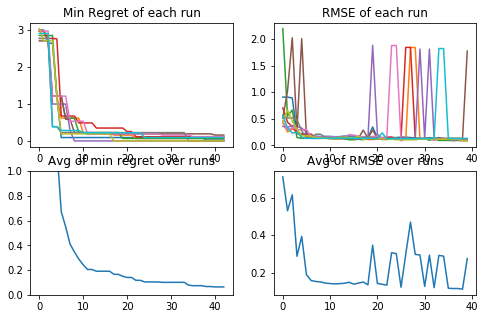

In [32]:
minregret_ALvar_ = np.empty(queries_ALvar_.shape)
for i in range(0, queries_ALvar_.shape[0]):
    minregret_ALvar_[i,:] = calc_min_regret(queries_ALvar_[i], Y_grid.max())  
    
plt.figure(figsize = FIGSIZE)
plt.subplot(2,2,1)
plt.plot(minregret_ALvar_.T)
plt.title('Min Regret of each run')
plt.subplot(2,2,3)
plt.plot(np.mean(minregret_ALvar_,axis = 0))
plt.title('Avg of min regret over runs')
plt.ylim((0,1))
plt.subplot(2,2,2)
plt.plot(rmse_ALvar_.T)
plt.title('RMSE of each run')
plt.subplot(2,2,4)
plt.plot(np.mean(rmse_ALvar_,axis = 0))
plt.title('Avg of RMSE over runs')

In [33]:
# Number of samples 
number_of_measurements = 3
number_of_repetitions = 10
number_of_iterations = 40
queries_ALUCB_ = np.empty((number_of_repetitions, number_of_iterations + number_of_measurements))
rmse_ALUCB_ = np.empty((number_of_repetitions,number_of_iterations))

for j in range(0, number_of_repetitions):
    
    # Random sample locations
    X_samples = np.random.uniform(-np.pi, np.pi * 3/4, (number_of_measurements, 1))

    # Get the function value with noise
    Y_samples = f(X_samples) + np.random.normal(0., .1, (X_samples.shape[0],1))

    # We will use this matrix to store the GP mean at every iteration.
    Y_estimates = np.full((len(X_grid), number_of_iterations),np.nan)
    
    # store the randomly sampled data
    queries_ALmean_[j,0:3] = Y_samples.ravel()
    
    for i in range(0, number_of_iterations):
    
        # Use GP regression to fit the data
        mean, Cov, variance, m = GP_analysis(X_samples, Y_samples, X_grid)
        
        # Compute UCB
        BO_beta = 2 * math.log(Dsize * math.pow(BO_number_of_iterations,2) * math.pow(np.pi,2) / (6 * BO_lambda) )
        alpha_full = mean + math.sqrt(BO_beta) * variance[:,None]
    
        # find the x value where the GP reaches a maximum
        next_sample_index = np.argmax(alpha_full)
    
        # add the desired sample to our data
        X_samples = np.vstack((X_samples,X_grid[next_sample_index,:]))
        Y_samples = np.vstack((Y_samples,Y_grid[next_sample_index,0]))
    
        # Store the GP mean for this iteration.
        Y_estimates[:,i] = mean.ravel()
        
        # Store the active learning sample
        queries_ALUCB_[j,i+3] = Y_grid[next_sample_index,0]
    rmse_ALUCB_[j,:] = calc_rmse(Y_estimates, Y_grid)

0
4881755404.232848
0
4919266117.855987
0
2632247615.856972
0
4808852520.215653
0
3791449597.4880376
0
4987614760.557521
0
2429403297.1392584
0
5006967870.226058
0
4348067543.607547
0
3150450632.0427575
0
4223585217.978915
0
5278025074.958133
0
2758219984.2165766
0
5555411790.225937
0
3690201998.030929
0
4319506502.496838
0
3223471419.7589684
0
5079416824.814879
0
5468197808.811139
0
4684812351.358088
0
3664782014.748053
0
2729864430.147167
0
4996784006.230338
0
4952492643.7876
0
5302251248.594258
0
5092719540.296508
0
3452766211.6335745
0
3749990776.7596664
0
3661741374.7437663
0
3696779427.641561


Text(0.5, 1.0, 'Avg of RMSE over runs')

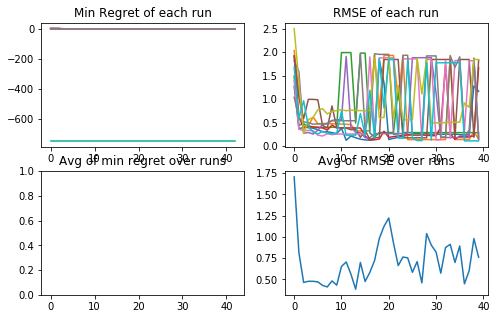

In [34]:
minregret_ALUCB_ = np.empty(queries_ALUCB_.shape)
for i in range(0, queries_ALUCB_.shape[0]):
    minregret_ALUCB_[i,:] = calc_min_regret(queries_ALUCB_[i], Y_grid.max())  
    
plt.figure(figsize = FIGSIZE)
plt.subplot(2,2,1)
plt.plot(minregret_ALUCB_.T)
plt.title('Min Regret of each run')
plt.subplot(2,2,3)
plt.plot(np.mean(minregret_ALUCB_,axis = 0))
plt.title('Avg of min regret over runs')
plt.ylim((0,1))
plt.subplot(2,2,2)
plt.plot(rmse_ALUCB_.T)
plt.title('RMSE of each run')
plt.subplot(2,2,4)
plt.plot(np.mean(rmse_ALUCB_,axis = 0))
plt.title('Avg of RMSE over runs')

Text(0.5, 1.0, 'Avg of RMSE over runs')

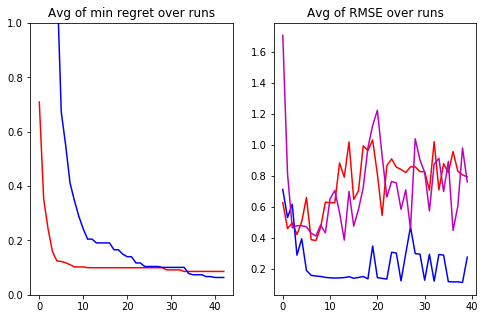

In [35]:
plt.figure(figsize = FIGSIZE)
plt.subplot(1,2,1)
plt.plot(np.mean(minregret_ALmean_,axis = 0),'r')
plt.plot(np.mean(minregret_ALvar_,axis = 0),'b')
plt.plot(np.mean(minregret_ALUCB_,axis = 0),'m')
plt.title('Avg of min regret over runs')
plt.ylim((0,1))

plt.subplot(1,2,2)
plt.plot(np.mean(rmse_ALmean_,axis = 0),'r')
plt.plot(np.mean(rmse_ALvar_,axis = 0),'b')
plt.plot(np.mean(rmse_ALUCB_,axis = 0),'m')
plt.title('Avg of RMSE over runs')